# Autotalker Batch Integration Mouse Organogenesis Imputed

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 16.02.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context
from sklearn.decomposition import KernelPCA

from autotalker.benchmarking import compute_rclisi, compute_cad
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=56, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 59986), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=56, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 59990), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=56, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 60006), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbir

### 1.2 Define Parameters

In [4]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_z2"
batch2 = "embryo1_z5"
batch3 = "embryo2_z2"
batch4 = "embryo2_z5"
batch5 = "embryo3_z2"
batch6 = "embryo3_z5"
n_neighbors = 4 # 12, 20
n_hvg_genes = 2000 # 4000

## Model
# AnnData Keys
counts_key = "log_normalized_counts" # raw counts not available
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"
mapping_entity_key = "mapping_entity"

# Architecture
active_gp_thresh_ratio = 0.03 # 0.01
gene_expr_recon_dist = "nb" # zinb
n_cond_embed = 3
log_variational = False # log normalized counts as input

# Trainer
n_epochs = 40
n_epochs_all_gps = 20
lr = 0.001
query_cond_embed_lr = 0.01
lambda_edge_recon = 0.01
lambda_gene_expr_recon = 0.0033
edge_batch_size = 512 # 128
node_batch_size = 64 # 16

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [ ]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [ ]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data

In [ ]:
adata_original = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_imputed.h5ad")

In [ ]:
# Use log normalized counts as raw counts are not available
adata_original.layers[counts_key] = adata_original.X

### 2.2 Prepare Data & GP Mask

#### 2.2.1 Filter Genes Based on GP Mask & HVG

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [ ]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [ ]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

In [ ]:
# Filter genes and only keep ligand, receptor, metabolitye enzyme, metabolite sensor and 
# highly variable genes (potential target genes of nichenet)
gp_dict_genes = get_unique_genes_from_gp_dict(gp_dict=combined_new_gp_dict,
                                              retrieved_gene_entities=["sources", "targets"])

omnipath_genes = get_unique_genes_from_gp_dict(gp_dict=omnipath_gp_dict,
                                               retrieved_gene_entities=["sources", "targets"])

mebocost_genes = get_unique_genes_from_gp_dict(gp_dict=mebocost_gp_dict,
                                               retrieved_gene_entities=["sources", "targets"])

nichenet_source_genes = get_unique_genes_from_gp_dict(gp_dict=nichenet_gp_dict,
                                                      retrieved_gene_entities=["sources"])

gp_relevant_genes = list(set(omnipath_genes + mebocost_genes + nichenet_source_genes))

# Keep only highly variable genes
sc.pp.highly_variable_genes(
    adata_original,
    n_top_genes=n_hvg_genes,
    batch_key="batch",
    subset=False)

adata_original.var["gp_relevant"] = adata_original.var.index.str.upper().isin(gp_relevant_genes)
adata_original.var["keep_gene"] = adata_original.var["gp_relevant"] | adata_original.var["highly_variable"]
adata_original = adata_original[:, adata_original.var["keep_gene"] == True]
print(f"Keeping {len(adata_original.var_names)} highly variable or gene program relevant genes.")
adata_original = adata_original[:, adata_original.var_names[adata_original.var_names.str.upper().isin(gp_dict_genes)].sort_values()]
print(f"Keeping {len(adata_original.var_names)} genes after filtering genes not in gp dict.")
adata_original = adata_original[:, (adata_original.X.sum(axis=0) > 0)]
print(f"Keeping {len(adata_original.var_names)} genes after removing genes with 0 expression.")
adata = adata_original.copy()

In [ ]:
# Split adata into different batches
adata_batch1 = adata[adata.obs["batch"] == batch1].copy() # reference
adata_batch2 = adata[adata.obs["batch"] == batch2].copy() # reference
adata_batch3 = adata[adata.obs["batch"] == batch3].copy() # reference
adata_batch4 = adata[adata.obs["batch"] == batch4].copy() # reference
adata_batch5 = adata[adata.obs["batch"] == batch5].copy() # query
adata_batch6 = adata[adata.obs["batch"] == batch6].copy() # query

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

### 2.3 Compute Spatial Neighbor Graphs

In [ ]:
for i in range(len(adata_batch_list)):
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch_list[i],
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch_list[i].obsp[adj_key] = adata_batch_list[i].obsp[adj_key].maximum(
        adata_batch_list[i].obsp[adj_key].T)

### 2.4 Combine Data for One-Shot Batch Integration

In [ ]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0] +
                                                  adata_batch_list[5].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                       (adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0] +
                                                         adata_batch_list[3].shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                       adata_batch_list[5].shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp[adj_key],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp[adj_key],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp[adj_key],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch_list[3].obsp[adj_key],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch_list[4].obsp[adj_key],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp[adj_key]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_one_shot.obsp[adj_key] = connectivities

### 2.5 Combine Data for Query-to-Reference Mapping

In [ ]:
# Reference
adata_reference = ad.concat(adata_batch_list[:-2], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0])))
connectivities_extension_batch4 = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp[adj_key],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp[adj_key],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp[adj_key],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4,
                                   adata_batch_list[3].obsp[adj_key]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4))

adata_reference.obsp[adj_key] = connectivities

In [ ]:
# Query
adata_query = ad.concat(adata_batch_list[-2:], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch5 = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                 (adata_batch_list[5].shape[0])))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[4].shape[0])))

connectivities_batch5 = sp.hstack((adata_batch_list[4].obsp[adj_key],
                                   connectivities_extension_batch5))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp[adj_key]))

connectivities = sp.vstack((connectivities_batch5,
                            connectivities_batch6))

adata_query.obsp[adj_key] = connectivities

In [ ]:
adata_reference_query = adata_one_shot.copy()

# Add mapping entity 
reference_batches = adata_reference.obs[condition_key].unique().tolist()
query_batches = adata_query.obs[condition_key].unique().tolist()
adata_reference_query.obs[mapping_entity_key] = None
adata_reference_query.obs.loc[adata_reference_query.obs[condition_key].isin(reference_batches), mapping_entity_key] = "reference"
adata_reference_query.obs.loc[adata_reference_query.obs[condition_key].isin(query_batches), mapping_entity_key] = "query"

### 2.6 Add GP Mask to Data

In [ ]:
for adata in adata_batch_list + [adata_one_shot, adata_reference, adata_query, adata_reference_query]:
    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key=gp_targets_mask_key,
        gp_sources_mask_key=gp_sources_mask_key,
        gp_names_key=gp_names_key,
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns[gp_names_key])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns[gp_names_key])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns[gp_names_key]), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm[gp_targets_mask_key].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm[gp_sources_mask_key].sum()}.")

In [ ]:
adata_one_shot.write(f"{model_artifacts_folder_path}/{dataset}_testing12.h5ad")

# 3. Model Training

### 3.2 One-Shot Batch Integration

#### 3.2.1 Initialize, Train & Save Model

In [ ]:
#del(model)
torch.cuda.empty_cache()
import gc
gc.collect()

In [ ]:
21022023_085233

In [ ]:
model_artifacts_folder_path = "../artifacts/seqfish_mouse_organogenesis/batch_integration/21022023_085233"
adata_one_shot = sc.read_h5ad(model_artifacts_folder_path + "/seqfish_mouse_organogenesis_testing4.h5ad")

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns[gp_names_key])

In [ ]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_layers_encoder=2,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/oneshot",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/oneshot",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

In [ ]:
# Compute latent nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_knng_key)

# Use Autotalker latent space for UMAP generation
sc.tl.umap(model.adata,
           neighbors_key=latent_knng_key)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("One-Shot Integration: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_oneshot.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)
#fig.savefig(f"{figure_folder_path}/latent_cell_types_oneshot.png",
#            bbox_inches="tight")

In [ ]:
model.adata.obsp["autotalker_recon_adj"] = model.get_recon_adj()

In [ ]:
# Save adata
model.adata.write(f"{model_artifacts_folder_path}/{dataset}_oneshot.h5ad")

In [5]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scvelo/settings.py:91: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore", category=cbook.mplDeprecation)


In [6]:
adata = cr.datasets.zebrafish()
adata

AnnData object with n_obs × n_vars = 2434 × 23974
    obs: 'Stage', 'gt_terminal_states', 'lineages'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors'
    obsm: 'X_force_directed'

In [7]:
# filter, normalize total counts and log-transform
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg annotation
sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X

Normalized count data: X.
This detected 2392 highly variable genes. 


In [10]:
adata

AnnData object with n_obs × n_vars = 2434 × 13690
    obs: 'Stage', 'gt_terminal_states', 'lineages', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors', 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_force_directed', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [9]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
from cellrank.tl.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata)

ValueError: Encountered NaN values in pseudotime.

In [18]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [19]:
adata = cr.datasets.zebrafish()
adata

AnnData object with n_obs × n_vars = 2434 × 23974
    obs: 'Stage', 'gt_terminal_states', 'lineages'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors'
    obsm: 'X_force_directed'

In [20]:
# filter, normalize total counts and log-transform
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg annotation
sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Normalized count data: X.
This detected 2392 highly variable genes. 
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


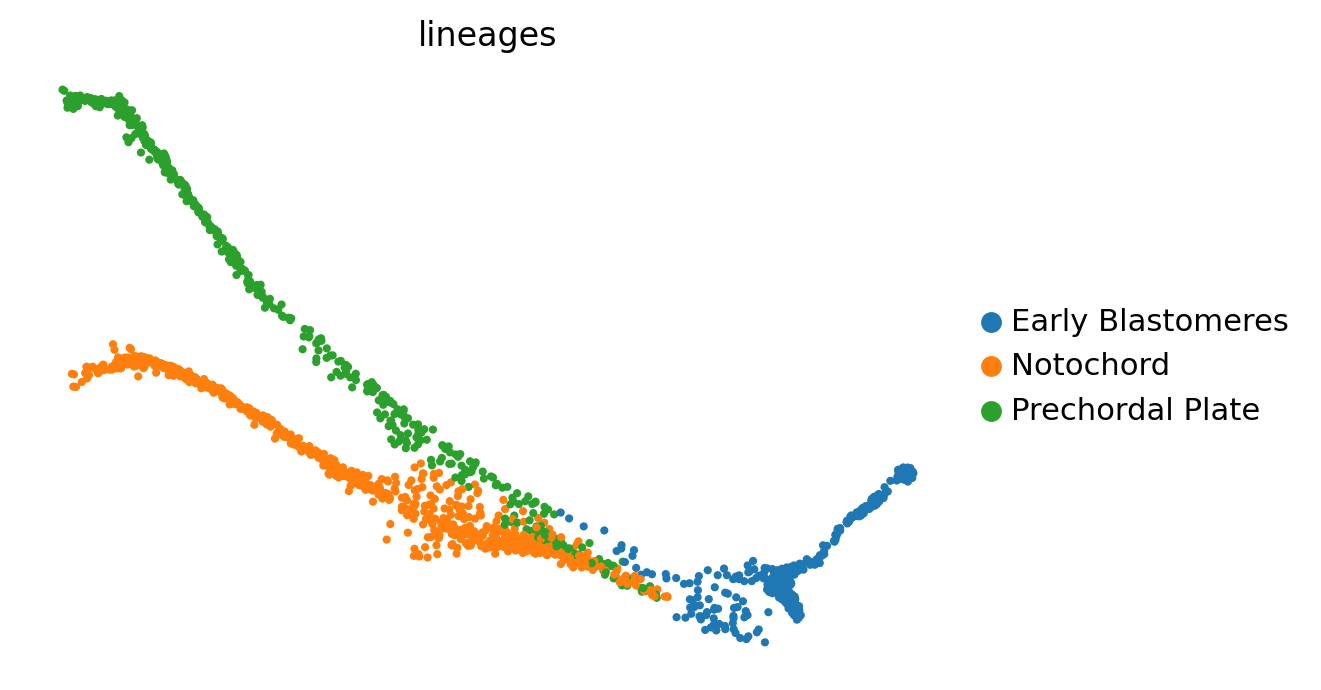

In [22]:
scv.pl.scatter(adata, basis="force_directed", c="lineages", legend_loc="right")

In [16]:
from cellrank.tl.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata)

Computing CytoTRACE score with `13690` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


ValueError: Encountered NaN values in pseudotime.

In [17]:
# import packages and load data
import scvelo as scv
import cellrank as cr
adata = cr.datasets.pancreas()

# standard pre-processing
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

# CytoTRACE by default uses imputed data - a simple way to compute KNN-imputed data is to use scVelo's moments
# function. However, note that this function expects `spliced` counts because it's designed for RNA velocity,
# so we're using a simple hack here:
if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:
    adata.layers['spliced'] = adata.X
    adata.layers['unspliced'] = adata.X

# compute KNN-imputation using scVelo's moments function
scv.pp.moments(adata)

# import and initialize the CytoTRACE kernel, compute transition matrix - done!
from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel(adata).compute_transition_matrix()

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `12987` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


ValueError: Encountered NaN values in pseudotime.